In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr

warnings.filterwarnings("ignore", module="scipy")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.13.0


In [2]:
RANDOM_SEED = 8924
az.style.use("arviz-darkgrid")

In [3]:
try:
    srrs2 = pd.read_csv(os.path.join("..", "data", "srrs2.dat"))
except FileNotFoundError:
    srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))

srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

In [4]:
try:
    cty = pd.read_csv(os.path.join("..", "data", "cty.dat"))
except FileNotFoundError:
    cty = pd.read_csv(pm.get_data("cty.dat"))

srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

In [5]:
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

In [6]:
srrs_mn.county = srrs_mn.county.map(str.strip)
county, mn_counties = srrs_mn.county.factorize()
srrs_mn["county_code"] = county
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

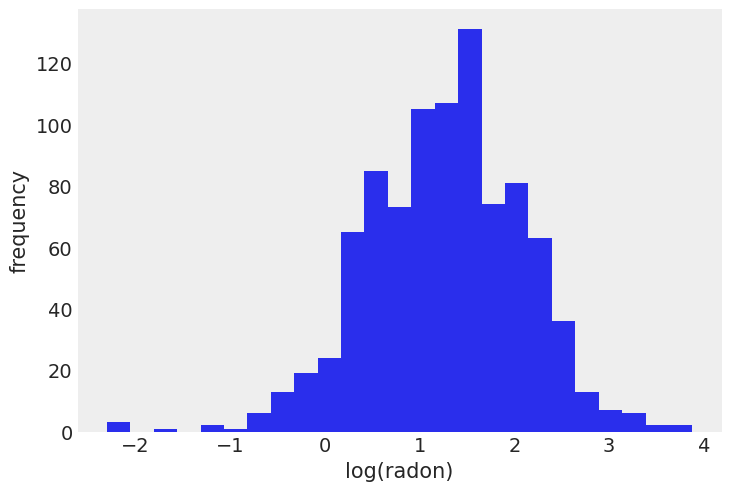

In [7]:
srrs_mn.log_radon.hist(bins=25, grid=False)
plt.xlabel("log(radon)")
plt.ylabel("frequency");

In [9]:
srrs_mn.columns

Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm',
       'county_code', 'log_radon'],
      dtype='object')

In [11]:
with pm.Model() as pooled_model:
    floor_ind = pm.MutableData("floor_ind", floor_measure, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.Exponential("sigma", 5)

    theta = alpha + beta * floor_ind

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

/Users/mori/anaconda3/envs/BayesianInference/lib/python3.10/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [14]:
with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [alpha, beta, sigma, y]


In [20]:
prior_checks

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [17]:
prior_checks.prior.squeeze(drop=True)

<xarray.Dataset> Size: 16kB
Dimensions:  (draw: 500)
Coordinates:
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    alpha    (draw) float64 4kB -6.044 6.814 -6.279 5.634 ... 12.79 -3.35 -4.057
    beta     (draw) float64 4kB -7.466 17.07 39.1 -0.9082 ... -12.99 11.13 5.035
    sigma    (draw) float64 4kB 0.07913 0.1304 0.04592 ... 0.3535 0.07662 0.0712
Attributes:
    created_at:                 2024-05-19T09:53:52.135353+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.13.0

In [18]:
prior["alpha"], prior["alpha"] + prior["beta"]

(<xarray.DataArray 'alpha' (draw: 500)> Size: 4kB
 array([-6.04441330e+00,  6.81434104e+00, -6.27943505e+00,  5.63442175e+00,
         2.26466246e+01, -1.08577283e+00,  9.58289958e-01, -7.18875235e+00,
        -1.21742096e+01, -1.18361729e+00,  3.36705651e+00, -2.41002148e+00,
         8.16558351e+00, -1.54126520e+01,  1.21392311e+01,  1.86765483e+01,
        -4.27636515e+00, -1.25271701e+01,  1.11439901e+01, -3.54594219e+00,
        -5.16042840e+00,  2.70094512e+00, -1.72834667e+01,  5.71986607e+00,
         1.76342580e-01, -1.45680944e+01, -6.40437791e+00, -2.63277009e+00,
         1.87605982e+01,  4.31114630e+00, -9.85249027e+00,  1.09459785e+01,
        -1.47769321e+01, -9.40092521e+00, -2.96932294e+00,  1.02639830e+01,
         1.05834070e+01, -9.37924632e+00, -1.90165182e+00,  8.52747978e+00,
        -1.36486983e-01,  6.98796303e-01,  5.22064034e+00, -1.15315352e+01,
         1.94033479e+01,  2.91354572e+00, -2.86717536e+00, -1.58756848e+01,
        -7.55232756e+00,  2.79143902e+

{<matplotlib.collections.PathCollection at 0x7fa902bb0370>}

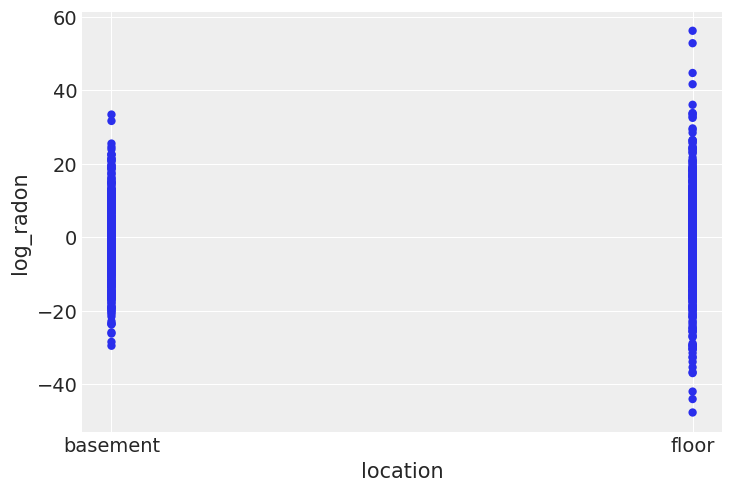

In [19]:
prior = prior_checks.prior.squeeze(drop=True)

{xr.concat(
    (
        prior["alpha"]
        , prior["alpha"] + prior["beta"]
    )
    , dim="location")
    .rename("log_radon")
    .assign_coords(location=["basement", "floor"])
    .plot.scatter(
        x="location"
        , y="log_radon"
        , edgecolors="none"
    )
}

In [21]:
with pooled_model:
    pooled_trace = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [22]:
az.summary(pooled_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.36,0.03,1.31,1.42,0.0,0.0,4272.19,3241.43,1.0
beta,-0.59,0.07,-0.72,-0.46,0.0,0.0,3903.73,3197.13,1.0
sigma,0.79,0.02,0.75,0.83,0.0,0.0,5394.58,3136.22,1.0


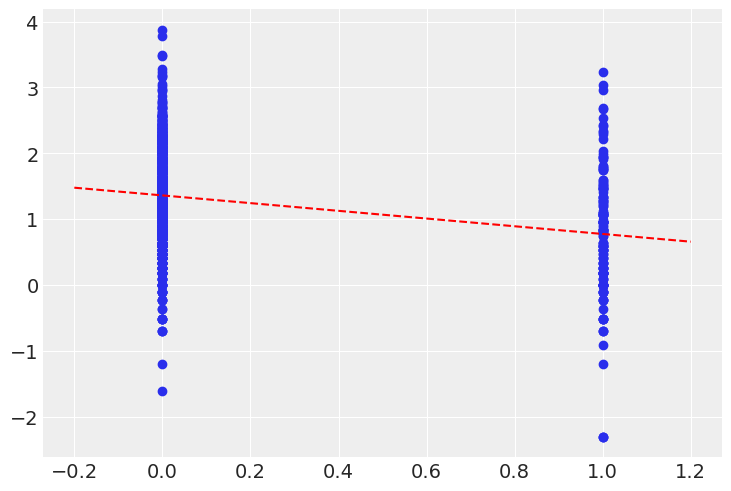

In [31]:
post_mean = pooled_trace.posterior.mean(dim=("chain", "draw"))

plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity + 0.1))
xvals = xr.DataArray(np.linspace(-0.2, 1.2))
plt.plot(xvals, post_mean["beta"] * xvals + post_mean["alpha"], "r--");

In [29]:
srrs_mn.floor

0      1
1      0
2      0
3      0
4      0
      ..
922    0
923    0
924    0
925    0
926    0
Name: floor, Length: 919, dtype: int64

In [34]:
county

array([ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       14, 14, 14, 14, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       19, 19, 19, 20, 20

In [33]:
coords = {"county": mn_counties}
# county, mn_counties = srrs_mn.county.factorize()
with pm.Model(coords=coords) as unpooled_model:
    floor_ind = pm.Data("floor_ind", floor_measure, dims="obs_id")

    alpha = pm.Normal("alpha", 0, sigma=10, dims="county")
    beta = pm.Normal("beta", 0, sigma=10)
    sigma = pm.Exponential("sigma", 1)

    theta = alpha[county] + beta * floor_ind

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")